In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
     ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Amit Prasad/Desktop/ONLY SALES/eccomerce sql'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host ="localhost",
                             username ="root",
                             password ="1234",
                             database ="ecommerce")

cur = db.cursor()


# List all unique cities where customers are located.

In [15]:
query = """ select distinct upper(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data)
df.head()

,0
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS


# Count the number of orders placed in 2017.

In [7]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total order placed in 2017 are ",data[0][0]

('total order placed in 2017 are ', 45101)

# Find the total sales per category.

In [8]:
query = """  select upper(products.product_category),
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [9]:
query = """ select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

" the pecentage of orders that were paid in installments is ",data[0][0]

(' the pecentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

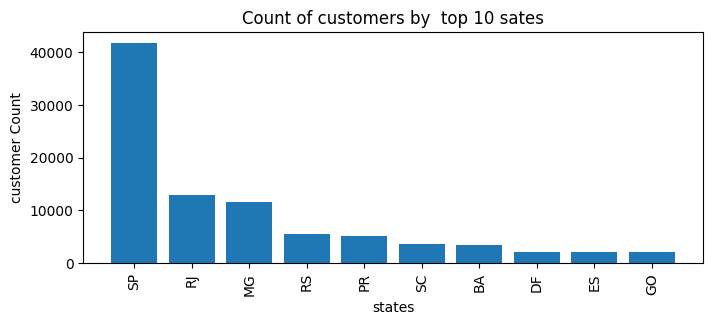

In [44]:
query = """ select customer_state , count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
df = df.head(10)
plt.figure(figsize = (8,3) )
plt.bar(df["state"],df["customer_count"])
plt.xlabel('states')
plt.ylabel('customer Count')
plt.title('Count of customers by  top 10 sates')
    
plt.xticks(rotation =90)
plt.show()

# Calculate the number of orders per month in 2018.

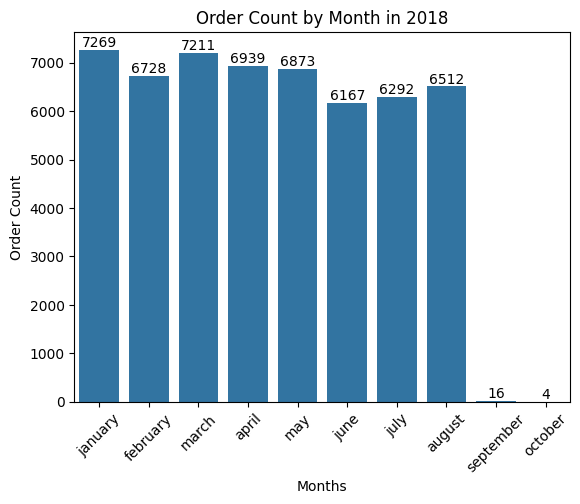

In [46]:
query = """
SELECT MONTHNAME(order_purchase_timestamp) AS months, COUNT(order_id) AS order_count
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["months", "order_count"])
df["months"] = df["months"].str.lower()
order = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october"]


ax = sns.barplot(x="months", y="order_count", data=df, order=order)
plt.xticks(rotation=45)
plt.xlabel('Months')
plt.ylabel('Order Count')
plt.title('Order Count by Month in 2018')
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [58]:
query = """
with count_per_order as 
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_order desc
"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns = ["customer city", "average orders per order"])
df.head(10)



,customer city,average orders per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [64]:
query = """  select upper(products.product_category),
round((sum(payments.payment_value) / (select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category order by sales_percentage desc;


"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [67]:
query = """  select upper(products.product_category),
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group  by products.product_category;

"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns = ["Category","order_count","price"])
df


,Category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,SPORT LEISURE,8641,114.34
2,COOL STUFF,3796,167.36
3,COMPUTER ACCESSORIES,7827,116.51
4,WATCHES PRESENT,5991,201.14
...,...,...,...
69,FLOWERS,33,33.64
70,KITCHEN PORTABLE AND FOOD COACH,15,264.57
71,HOUSE COMFORT 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


# Calculate the total revenue generated by each seller, and rank them by revenue.

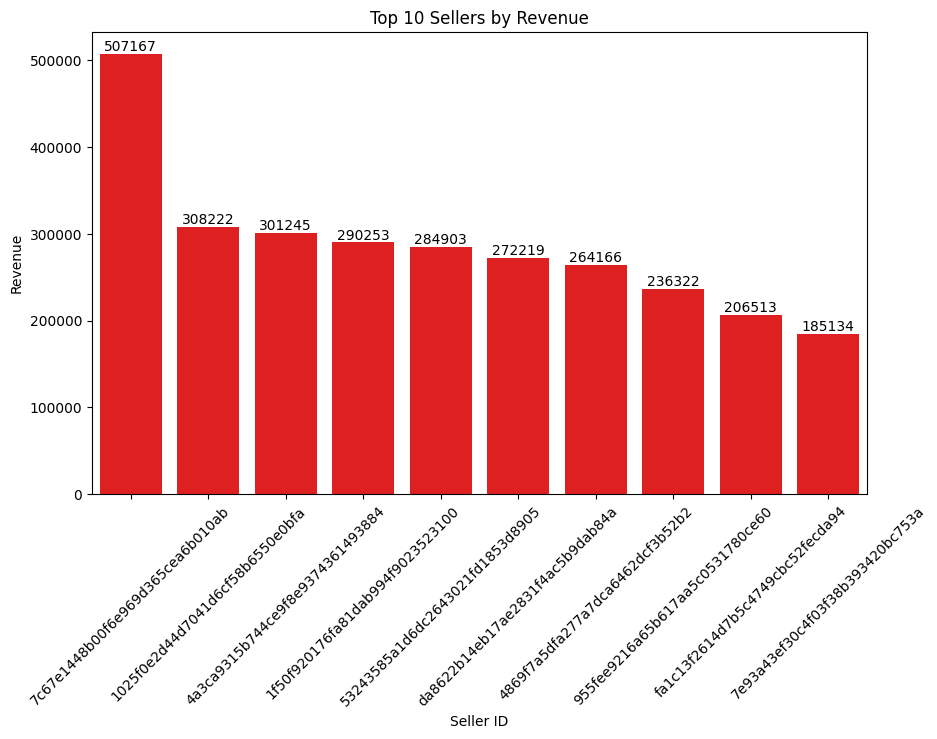

In [97]:
query = """
SELECT *, dense_rank() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])


df = df.head(10)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x="seller_id", y="revenue", data=df, color='red')

plt.xlabel('Seller ID')
plt.ylabel('Revenue')
plt.title('Top 10 Sellers by Revenue')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])

plt.show()